In [34]:
import math
import torch
from torch import nn
import sys
sys.path.append('..')
import myd2l
import time

In [35]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = myd2l.load_data_pth(batch_size, max_window_size, num_noise_words)

In [36]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(embed.weight.shape)
print(embed.weight.dtype)

torch.Size([20, 4])
torch.float32


In [37]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(embed(x))

tensor([[[ 0.5098, -0.3107, -0.6984,  1.0787],
         [-1.1896, -1.1750, -0.2973, -1.6300],
         [ 0.0414, -0.5474,  0.1089, -0.0583]],

        [[ 1.0776,  0.0227,  0.4126, -0.0740],
         [ 0.0358, -1.6578, -0.4039,  1.3374],
         [ 0.8109,  2.4885, -0.2999,  0.6384]]], grad_fn=<EmbeddingBackward0>)


In [38]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [39]:
print(skip_gram(torch.ones((2, 1), dtype=torch.long), torch.ones((2, 4), dtype=torch.long), embed, embed).shape)


torch.Size([2, 1, 4])


In [40]:
class SigmoidBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, inputs, targets, mask=None):
        # logits 是指应用 Sigmoid 函数之前的输入值
        out = nn.functional.binary_cross_entropy_with_logits(inputs, targets, weight=mask, reduction='none')
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [41]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
print(loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1))

tensor([0.9352, 1.8462])


In [42]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [43]:
embed_size = 100
net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size)
    )

In [50]:
def train(net, data_iter, lr, num_epochs, device=torch.device('cuda')):
    def init_weights(m):
        if isinstance(m, nn.Embedding):
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    losses = []
    time_start = time.time()
    tokens_sum = 0
    for epoch in range(num_epochs):
        for batch in data_iter:
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = loss(pred.reshape(label.shape).float(), label.float(), mask) / mask.sum(axis=1) * mask.shape[1]
            tokens_sum += mask.shape[0] * mask.shape[1]
            l.sum().backward()
            optimizer.step()
        losses.append(l.mean().item())
        print(f'epoch {epoch + 1:d}, loss {losses[-1]:3f}')

    ax = myd2l.build_ax('epoch', 'loss')
    ax.plot(range(1, num_epochs + 1), losses)
    print(f'{tokens_sum / (time.time() - time_start):.1f} tokens/sec')

epoch 1, loss 0.438859
epoch 2, loss 0.414809
epoch 3, loss 0.398874
epoch 4, loss 0.375232
epoch 5, loss 0.362778
1736569.0 tokens/sec


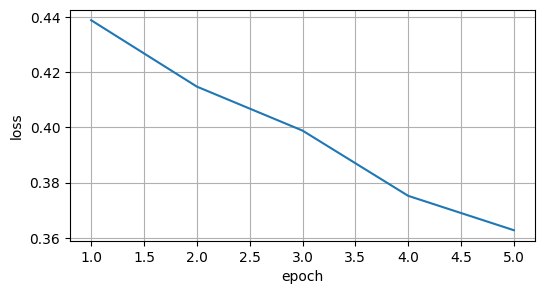

In [51]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [58]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    print(cos.shape)
    topk = torch.topk(cos, k=k + 1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:
        print(f'cosine sim = {cos[i]:.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

torch.Size([6720])
cosine sim = 0.755: microprocessor
cosine sim = 0.732: intel
cosine sim = 0.658: chips


In [59]:
W = net[0].weight.data
x = W[0]
print(W.shape, x.shape, torch.mv(W, x).shape)

torch.Size([6720, 100]) torch.Size([100]) torch.Size([6720])
